## 单目相机标定
本次数据集为实验室相机拍摄所得，共用此数据集的人员有：丁悦林、何相杰。

总共拍摄50多张图像，我从中选取20张作为实验使用的数据。  
棋盘格宽度6mm，内角点11*8

In [8]:
import os
import glob
import numpy as np
import cv2
import shutil
import matplotlib
import matplotlib.pyplot as plt

In [2]:
try:
    shutil.rmtree(matplotlib.get_cachedir())
except:
    pass
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [9]:
class CameraCalibrator:
    def __init__(self, img_dir, corner_shape, size):
        self.img_dir = img_dir
        self.corner_shape = corner_shape
        self.size = size
        # 内外参、畸变系数
        self.inner_matrix = None
        self.vector_r,self.vector_t = None,None
        self.dis_coeff = None

        w,h = corner_shape
        # cp:corner points
        cp_int = np.zeros((w*h, 3), np.float32)
        cp_int[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2) # 按顺序排列的坐标
        self.cp_world = cp_int * size # (w*h,3):每一行为(X,Y,Z)

        self.img_paths = []
        self.img_paths += glob.glob(os.path.join(img_dir, "*.bmp"))
        assert len(self.img_paths),"路径加载图像失败"
    
    def calibrate_camera(self):
        '''
        相机标定，返回重投影误差、内外参、畸变系数
        '''
        w, h = self.corner_shape
        # 存储每一张img的坐标
        points_world = []
        points_pixel = []
        imgs_with_corners = []
        for idx,img_path in enumerate(self.img_paths):
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # 寻找角点，cp_img是像素空间中的角点坐标
            ret, cp_img = cv2.findChessboardCorners(img_gray, (w, h), None)
            if ret:
                # 亚像素角点精细化
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
                cp_img = cv2.cornerSubPix(img_gray, cp_img, (11, 11), (-1, -1), criteria)
                points_world.append(self.cp_world)
                points_pixel.append(cp_img)
                
                # 准备可视化
                img_with_corners = img.copy()
                cv2.drawChessboardCorners(img_with_corners, (w, h), cp_img, ret) # 绘制角点
                img_rgb = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
                imgs_with_corners.append(img_rgb)
            else:
                print(f"第{idx+1}个图像角点检测失败")

        # 可视化
        self._visualize_corners(imgs_with_corners)

        # 相机标定
        ret, inner_matrix, dis_coeff, vector_r, vector_t = cv2.calibrateCamera(points_world, points_pixel, img_gray.shape[::-1], None, None)
        # 保存内外参、畸变系数
        self.inner_matrix = inner_matrix
        self.dis_coeff = dis_coeff
        self.vector_r,self.vector_t = vector_r,vector_t
        
        return ret, inner_matrix, dis_coeff, vector_r, vector_t

    def _visualize_corners(self, imgs_with_corners):
        '''
        可视化角点
        '''
        n_images = len(imgs_with_corners)
        cols = min(5, n_images)
        rows = (n_images+cols-1) // cols
        
        fig = plt.figure(figsize=(5*cols, 4*rows))
        for idx,img in enumerate(imgs_with_corners):
            ax = fig.add_subplot(rows, cols, idx+1)
            ax.imshow(img)
            ax.set_title(f"{idx+1}", fontsize=10)
            ax.axis('off')
        
        plt.tight_layout()
        plt.suptitle("角点检测结果")
        plt.show()
    
    def visualize_poses(self):
        """
        可视化所有标定板在相机坐标系下的3D位姿
        """
        if self.vector_r is None or self.vector_t is None:
            print("需要先进行相机标定")
            return
        
        fig = plt.figure(figsize=(14, 11))
        ax = fig.add_subplot(111, projection='3d')
        
        w, h = self.corner_shape
        
        # 收集所有标定板的点，计算场景范围（单位：毫米）
        all_points_list = []
        for rvec, tvec in zip(self.vector_r, self.vector_t):
            R, _ = cv2.Rodrigues(rvec)
            # 转换到相机坐标系并转换为毫米
            transformed_points = (R @ self.cp_world.T + tvec).T * 1000  # 米 -> 毫米
            all_points_list.append(transformed_points)
        
        all_points_np = np.vstack(all_points_list)
        
        # 计算场景的边界范围
        min_coords = all_points_np.min(axis=0)
        max_coords = all_points_np.max(axis=0)
        scene_range = (max_coords - min_coords).max()
        scene_center = (min_coords + max_coords) / 2
        
        # 绘制相机坐标系
        # 坐标轴长度设置为场景范围的25%，确保清晰可见
        axis_length = scene_range * 0.25
        arrow_length_ratio = 0.15
        # 原点
        ax.scatter([0], [0], [0], c='black', marker='o', s=150, 
                label='相机光心', zorder=100, edgecolors='white', linewidths=2)
        # X轴
        ax.quiver(0, 0, 0, axis_length, 0, 0, 
                color='red', arrow_length_ratio=arrow_length_ratio, 
                linewidth=3.5, label='Xc', alpha=0.9)
        # Y轴
        ax.quiver(0, 0, 0, 0, axis_length, 0, 
                color='green', arrow_length_ratio=arrow_length_ratio, 
                linewidth=3.5, label='Yc', alpha=0.9)
        # Z轴
        ax.quiver(0, 0, 0, 0, 0, axis_length, 
                color='blue', arrow_length_ratio=arrow_length_ratio, 
                linewidth=3.5, label='Zc', alpha=0.9)
        
        # 绘制所有标定板（毫米）
        # 为每个标定板分配不同的颜色
        prop_cycler = plt.rcParams['axes.prop_cycle']
        colors = prop_cycler.by_key()['color']
        
        for idx, (rvec, tvec) in enumerate(zip(self.vector_r, self.vector_t)):
            # 将旋转向量转换为旋转矩阵
            R, _ = cv2.Rodrigues(rvec)
            
            # 将棋盘格的所有世界坐标点转换到相机坐标系下
            transformed_points = (R @ self.cp_world.T + tvec).T * 1000  # 米 -> 毫米
            
            # 为当前标定板选择一个颜色
            color = colors[idx % len(colors)]
            
            # 绘制完整的棋盘格网格
            # 绘制水平线
            for j in range(h):
                row_points = transformed_points[j*w : (j+1)*w]
                ax.plot(row_points[:, 0], row_points[:, 1], row_points[:, 2], 
                        color=color, linewidth=1.2, alpha=0.8)
            
            # 绘制垂直线
            for i in range(w):
                col_points = transformed_points[i::w]
                ax.plot(col_points[:, 0], col_points[:, 1], col_points[:, 2], 
                        color=color, linewidth=1.2, alpha=0.8)
        
        # 优化坐标轴范围和比例
        # 扩展范围以包含原点和所有标定板，并留有足够边距
        plot_radius = max(scene_range * 0.65, np.linalg.norm(scene_center) * 0.8)
        
        # 计算最终的绘图中心（在原点和场景中心之间）
        plot_center = scene_center * 0.4
        
        # 设置等比例的坐标轴范围
        ax.set_xlim(plot_center[0] - plot_radius, plot_center[0] + plot_radius)
        ax.set_ylim(plot_center[1] - plot_radius, plot_center[1] + plot_radius)
        ax.set_zlim(plot_center[2] - plot_radius, plot_center[2] + plot_radius)
        
        # 强制设置相等的纵横比
        ax.set_box_aspect([1, 1, 1])

        ax.set_xlabel('Xc (mm)', fontsize=13, labelpad=12, weight='bold')
        ax.set_ylabel('Yc (mm)', fontsize=13, labelpad=12, weight='bold')
        ax.set_zlabel('Zc (mm)', fontsize=13, labelpad=12, weight='bold')
        ax.set_title('标定板在相机坐标系下的位置和姿态', 
                     fontsize=16, pad=25, weight='bold')
        ax.legend(loc='upper right', fontsize=11, framealpha=0.95, 
                edgecolor='black', fancybox=True)
        
        # 设置视角：仰角 20°，方位角 -120°
        ax.view_init(elev=20, azim=-120)
        # 设置网格样式
        ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
        # 设置背景颜色
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        plt.tight_layout()
        plt.show()

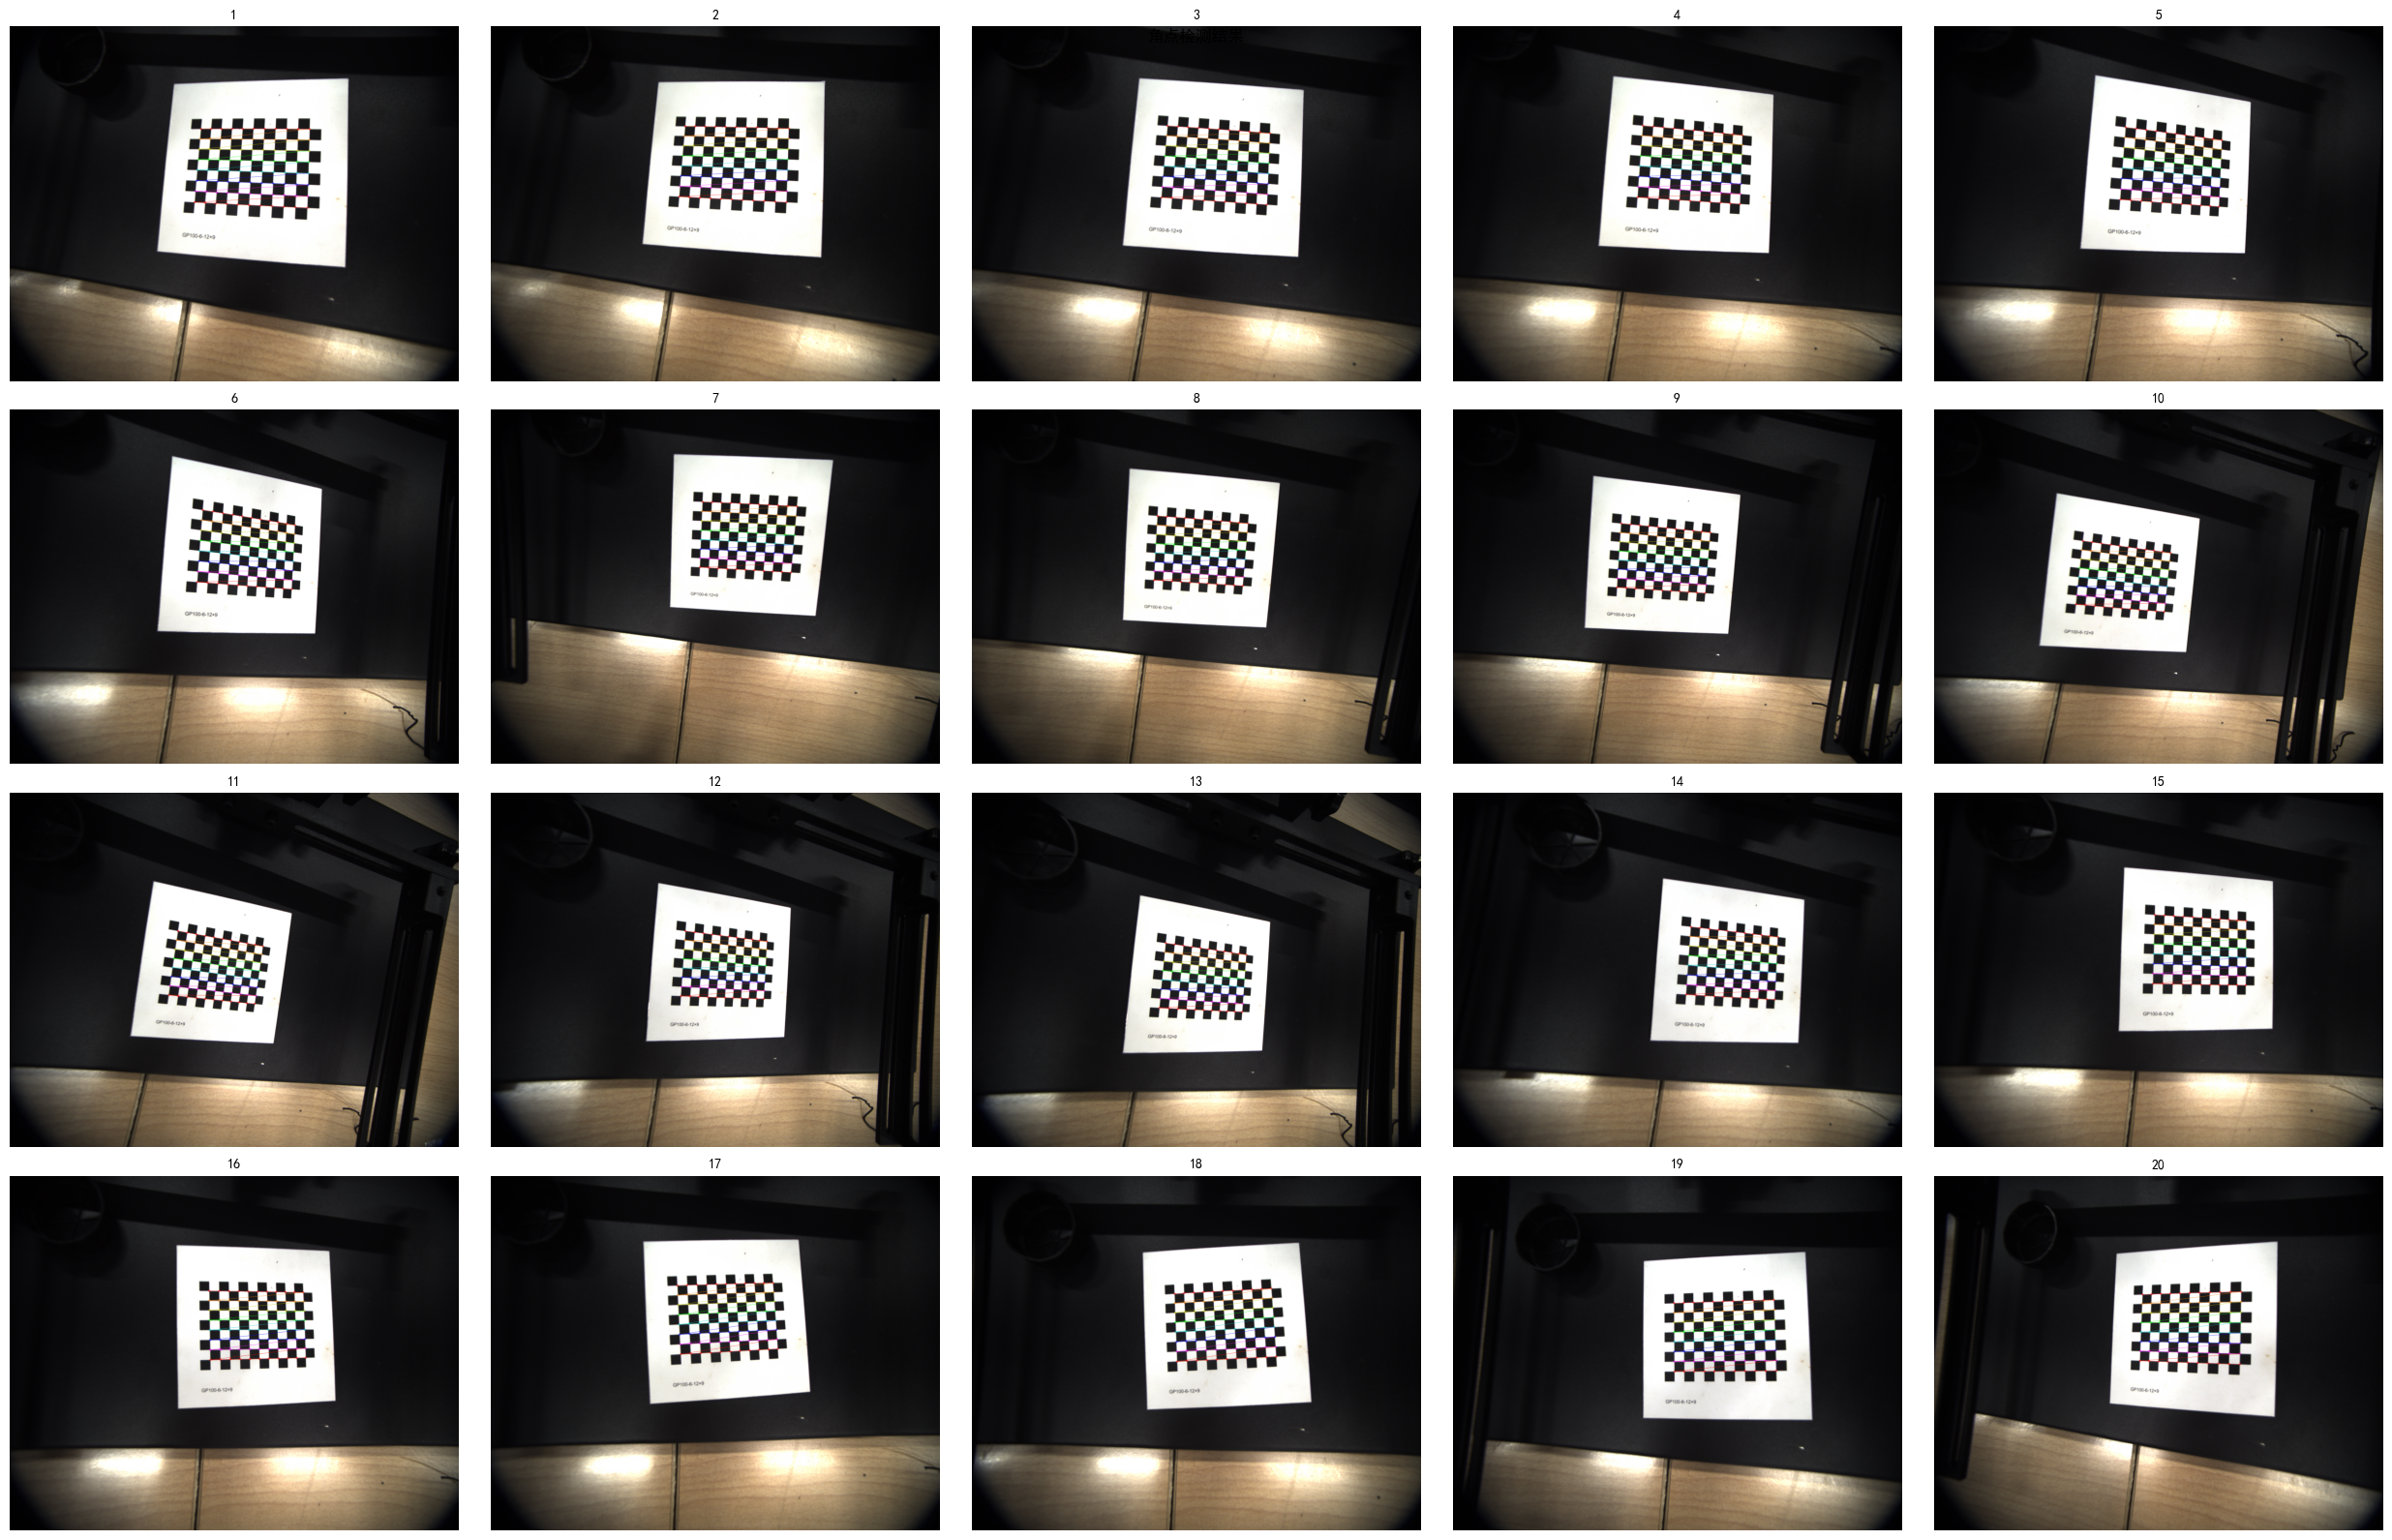

In [10]:
img_dir = "./my_camera/img_clean"
corner_shape = (11,8)
size = 0.006
camera_calibrator = CameraCalibrator(img_dir, corner_shape, size)
ret, inner_matrix, dis_coeff, vector_r, vector_t = camera_calibrator.calibrate_camera()
# 转换得到旋转矩阵R
matrices_R = [cv2.Rodrigues(r)[0] for r in vector_r]

In [11]:
print (f"重投影误差：{ret}像素")
# 内参
print (f"内参矩阵：\n {inner_matrix}")
print (f"畸变系数：\n {dis_coeff}") # (k_1, k_2, p_1, p_2, k_3)
# 外参
print (f"旋转矩阵R：\n {matrices_R}")
print (f"平移向量t：\n {vector_t}")

重投影误差：0.08132900557315116像素
内参矩阵：
 [[1.31024463e+03 0.00000000e+00 1.32999219e+03]
 [0.00000000e+00 1.30968768e+03 1.01816574e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
畸变系数：
 [[-0.08487011  0.09225345 -0.00077815 -0.00018567 -0.03919894]]
旋转矩阵R：
 [array([[ 0.98741369, -0.06287376,  0.14512442],
       [ 0.04859529,  0.9938081 ,  0.09991977],
       [-0.15050816, -0.09160978,  0.98435509]]), array([[ 0.99298794, -0.06353367,  0.09969161],
       [ 0.05414224,  0.99407638,  0.09423788],
       [-0.10508836, -0.08817955,  0.99054571]]), array([[ 0.99763206, -0.06799394, -0.01034858],
       [ 0.06856585,  0.99502699,  0.07224967],
       [ 0.00538457, -0.07278815,  0.99733289]]), array([[ 0.99314155, -0.05737959, -0.10186978],
       [ 0.06350669,  0.99629712,  0.05795643],
       [ 0.09816705, -0.06402835,  0.99310805]]), array([[ 0.97836085, -0.06106036, -0.19769085],
       [ 0.07006573,  0.99678453,  0.03887661],
       [ 0.19468136, -0.05188671,  0.9794932 ]]), array([[ 0

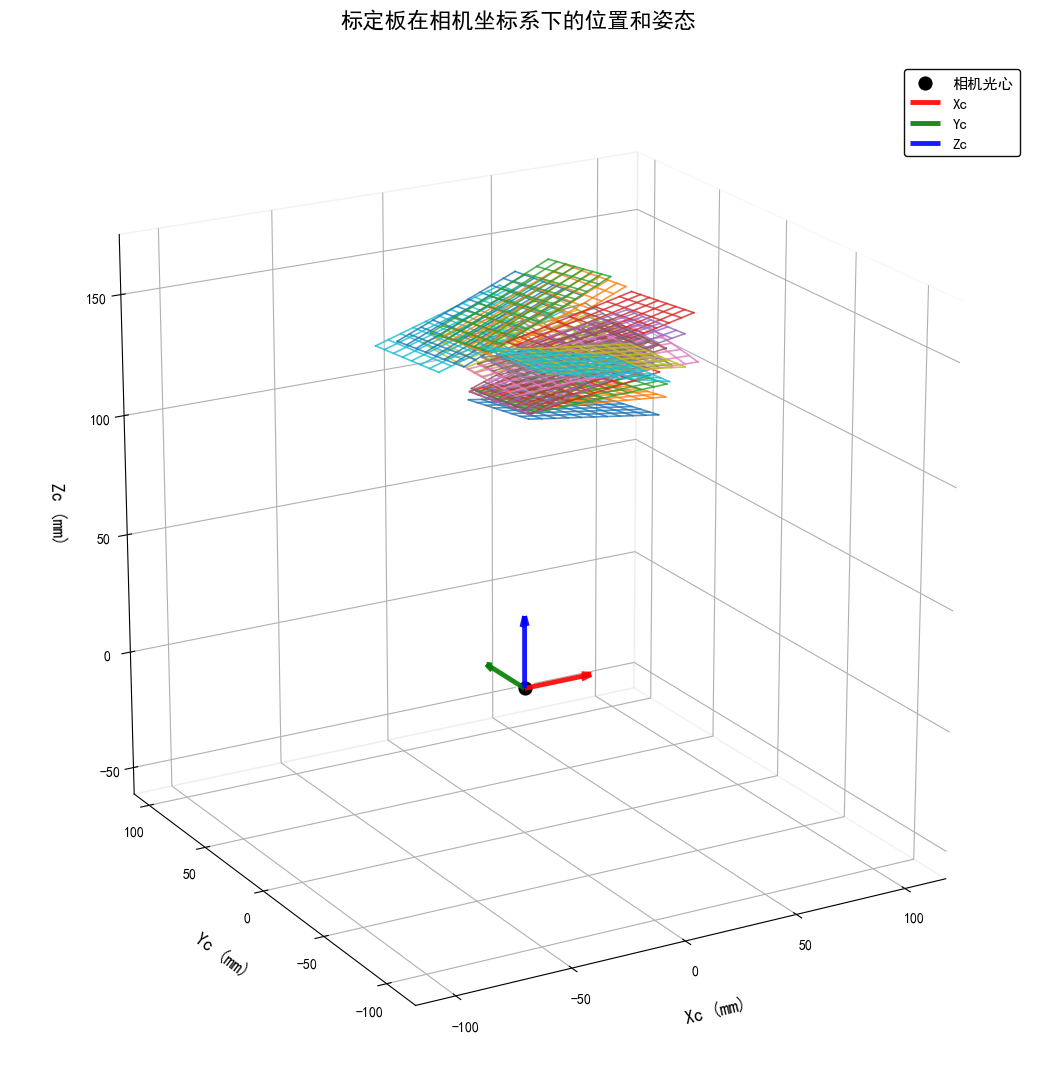

In [12]:
camera_calibrator.visualize_poses()